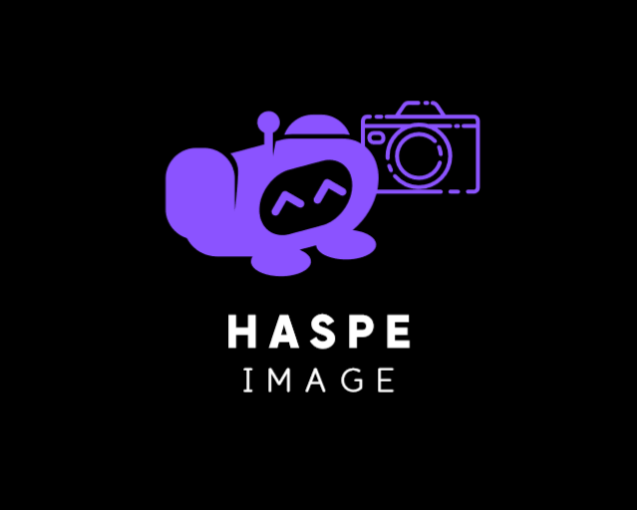

# **Installing and Importing Libraries**

In [1]:
!pip install python-telegram-bot
!pip install nest_asyncio
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install google-cloud-vision
!pip install joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nest_asyncio
nest_asyncio.apply()

import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from google.cloud import vision_v1
from IPython.display import display, Audio
import time
import torch
import joblib
import moviepy.editor as mp

# **Importing the Saved Model and Defining Functions**

In [4]:
# Function to detect text from an image using Google Cloud Vision API
def detect_text_from_image(image_content):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Image Detection/credentials.json"

    vision_client = vision_v1.ImageAnnotatorClient()

    image = vision_v1.Image(content=image_content)

    response = vision_client.text_detection(image=image)

    texts = response.text_annotations
    detected_text = ""
    for text in texts:
        detected_text += text.description + " "

    return detected_text.strip()

# Function to classify hate speech in the extracted text
def predict_hate_speech_image(image_content, model, tokenizer, label_encoder, device):
    # Extract text from image using Google Cloud Vision API
    image_text = detect_text_from_image(image_content)

    # Use the Hate Speech Detection model for prediction
    #predicted_label = predict_hate_speech(image_text, model, tokenizer, label_encoder, device)
    predicted_label = load_model_and_predict(image_text)

    return predicted_label

# Define loaded_model as a global variable
loaded_model = None

# Function to load the model and return the loaded model along with other objects
def load_model_and_predict(text):
    global loaded_model  # Access the global variable
    # Load the BERT model and tokenizer
    model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
    loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
    loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

    # Load the TensorFlow model
    tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

    # Load the label encoder
    label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
    loaded_label_encoder = joblib.load(label_encoder_filename)

    # Tokenize and preprocess the input text
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    return loaded_model, loaded_tokenizer, loaded_label_encoder, predicted_label

# **Code for Bot 3 - Haspe Image**

In [5]:
# Commands and message handling for the Haspe Image Bot
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe Image Bot.')

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am the Haspe Image Bot! Please Upload Image so I can predict if it contains hate speech.')

async def image_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Please Upload the Image!')

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    # Check if the received message contains an image
    if update.message.photo:
        await handle_image(update, context)
    else:
        await update.message.reply_text('The given input is not in image format. Please enter Image as Input.')

async def handle_image(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Processing your Image. Please wait...')
    global loaded_model  # Access the global variable
    # Get the largest available photo (highest resolution)
    photo = update.message.photo[-1]
    # Get the corresponding File object
    file = await context.bot.get_file(photo.file_id)
    # Download the file content as bytearray
    image_content_bytearray = await file.download_as_bytearray()
    # Convert the bytearray to bytes
    image_content_bytes = bytes(image_content_bytearray)
    # Detect text from the image
    image_text = detect_text_from_image(image_content_bytes)
    # Take only the first half of the extracted text
    image_text_half = image_text[:len(image_text) // 2]
    # Predict hate speech from the extracted text
    loaded_model, loaded_tokenizer, loaded_label_encoder, predicted_label = load_model_and_predict(image_text_half)

    # Modify the predicted label output
    if predicted_label.lower() == 'yes':
        prediction_output = 'Hate'
    else:
        prediction_output = 'Non-Hate'

    # Send the prediction back to the user
    await update.message.reply_text(f'Text Extracted from Image: "{image_text_half}"\nHate Speech Prediction for Image: {prediction_output}')

def error(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f'Update {update} caused error {context.error}')

In [ ]:
if __name__ == '__main__':
    TOKEN = 'Telegram Bot API Token'
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help', help_command))
    app.add_handler(CommandHandler('image', image_command))
    app.add_handler(MessageHandler(filters.ALL, handle_message))

    # Error handling
    app.add_error_handler(error)

    # Poll the bot
    print('Polling...')
    app.run_polling(poll_interval=3)

Polling...
